## Hotwater Data
Dataset
Assume user downloaded archive.zip from Kaggle,
renamed the file BuildingData.zip,
and stored the file in the data subdirectory.
Assume the zip file contains the hotwater.csv file.  

In [11]:
DATAPATH=''
try:
    # On Google Drive, set path to my drive / data directory.
    from google.colab import drive
    IN_COLAB = True
    PATH='/content/drive/'
    drive.mount(PATH)
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
except:
    # On home computer, set path to local data directory.
    IN_COLAB = False
    DATAPATH='C:/'  # must end in "/"

ZIP_FILE='BuildingData.zip'
ZIP_PATH = DATAPATH+ZIP_FILE
HOTWATER_FILE='hotwater.csv'
MODEL_FILE='Model'  # will be used later to save models

In [12]:
from os import listdir
import csv
from zipfile import ZipFile
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot

from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler

from statsmodels.tsa.arima.model import ARIMA

import matplotlib.pyplot as plt
from matplotlib import colors
mycmap = colors.ListedColormap(['red','blue'])  # list color for label 0 then 1
np.set_printoptions(precision=2)

In [13]:
def read_zip_to_panda(zip_filename,csv_filename):
    zip_handle = ZipFile(zip_filename)
    csv_handle = zip_handle.open(csv_filename)
    panda = pd.read_csv(csv_handle)
    return panda
def fix_date_type(panda):
    # Convert the given timestamp column to the pandas datetime data type.
    panda['timestamp'] = pd.to_datetime(panda['timestamp'], infer_datetime_format = True)
    indexed = panda.set_index(['timestamp'])
    return indexed
def get_site_timeseries(panda,site):
    # Assume the panda dataframe has a datetime column.
    # (If not, call fix_date_type() before this.)
    # Extract the timeseries for one site.
    # Convert the datetime column to a DatetimeIndex.
    site_df = panda[panda['site_id']==site]
    temp_col = site_df['date']
    temp_val = temp_col.values
    temp_ndx = pd.DatetimeIndex(temp_val)
    dropped = site_df.drop('date',axis=1)
    panda = dropped.set_index(temp_ndx)
    return panda

In [16]:
hotwater_df = read_zip_to_panda(ZIP_PATH,HOTWATER_FILE)
hotwater_df = fix_date_type(hotwater_df)
print(hotwater_df.info()) 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17544 entries, 2016-01-01 00:00:00 to 2017-12-31 23:00:00
Columns: 185 entries, Robin_public_Carolina to Cockatoo_assembly_Ralph
dtypes: float64(185)
memory usage: 24.9 MB
None


In [17]:
cols=hotwater_df.columns
all_sites=[s.split('_')[0] for s in cols]  # Site is first part of building name like Hog_parking_Linda
uniq_sites = [x for x in set(all_sites)]
site_counts = [[x,all_sites.count(x)] for x in set(all_sites)]
print("Note we only have a few sites!")
print("Buildings per site:\n",site_counts)

Note we only have a few sites!
Buildings per site:
 [['Swan', 16], ['Moose', 3], ['Robin', 15], ['Fox', 68], ['Eagle', 60], ['Cockatoo', 2], ['Bobcat', 16], ['Crow', 5]]


## Plot hotwater usage per site


In [18]:
# Plot hotwater time series for one column (building). 
show_all_plots = False
if show_all_plots:
    cols=hotwater_df.columns
    uniq_sites = [x for x in set(all_sites)]
    for site in uniq_sites:
        for bldg in cols:
            if bldg.startswith(site):
                temp_df = hotwater_df[bldg]
                temp_df.plot(figsize=(20,5))
        plt.title("Steam for site "+site)
        plt.show()

Two sites Fox and Eagle; Fox has 18 buildings and Eagle has 19 buildings

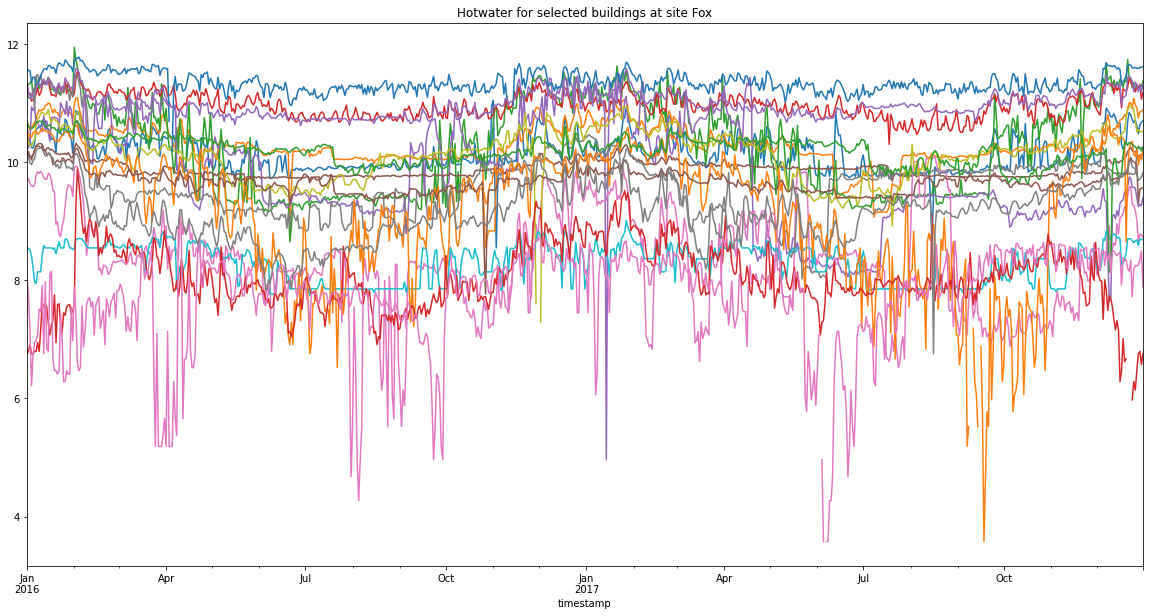

Site Fox has good steam data from 18 buildings:
 ['Fox_education_Andre', 'Fox_office_Alice', 'Fox_assembly_Gary', 'Fox_education_Yolande', 'Fox_assembly_Renna', 'Fox_lodging_Wallace', 'Fox_education_Geoffrey', 'Fox_lodging_Angla', 'Fox_lodging_Helen', 'Fox_education_Louie', 'Fox_education_Otilia', 'Fox_education_Elizabeth', 'Fox_education_Eldon', 'Fox_food_Francesco', 'Fox_education_Claude', 'Fox_education_Marlana', 'Fox_education_Heriberto', 'Fox_education_Wendell']


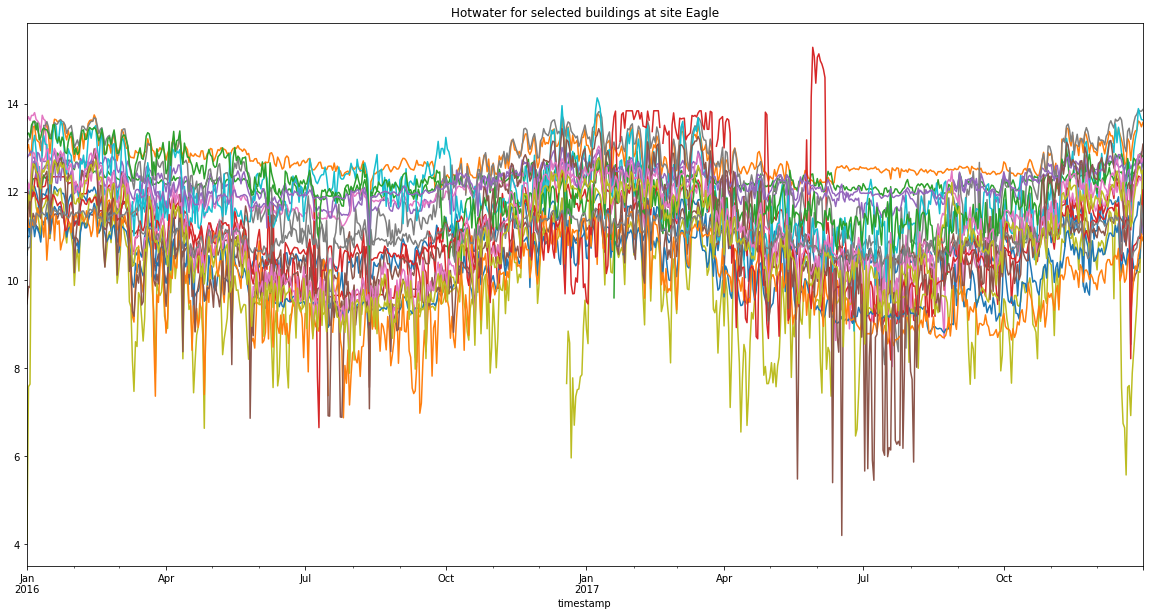

Site Eagle has good steam data from 19 buildings:
 ['Eagle_office_Ryan', 'Eagle_office_Sonya', 'Eagle_education_Shanna', 'Eagle_office_Efrain', 'Eagle_education_Lino', 'Eagle_office_Jeff', 'Eagle_education_Wesley', 'Eagle_assembly_Lacy', 'Eagle_lodging_Andy', 'Eagle_assembly_Ian', 'Eagle_office_Jackie', 'Eagle_assembly_Estelle', 'Eagle_education_Samantha', 'Eagle_office_Mable', 'Eagle_office_Demetra', 'Eagle_education_Alberto', 'Eagle_assembly_Latrina', 'Eagle_public_Missy', 'Eagle_assembly_Josie']


In [20]:
# Plot hotwater time series for one column (building). 
cols=hotwater_df.columns
uniq_sites = [x for x in set(all_sites)]
show_legend = False
for site in uniq_sites:
    suitable_bldgs=[]
    for bldg in cols:
        if bldg.startswith(site):  # and 'education' in bldg and bldg.endswith('ll'):
            temp_df = hotwater_df[bldg]
            smooth = temp_df.resample("1D").mean()  
            count_nan=np.isnan(smooth).sum()
            count_zero=smooth.isin([0]).sum()
            if count_nan<=0 and count_zero<=5:
                suitable_bldgs.append(bldg)
                np.seterr(divide = 'ignore') 
                logs = np.log(smooth)
                logs.plot(figsize=(20,10))
                np.seterr(divide = 'warn') 
    num_bldg = len(suitable_bldgs)
    if num_bldg>0:
        plt.title("Hotwater for selected buildings at site "+site)
        if show_legend:
            plt.legend()
        plt.show()
        print("Site",site,"has good steam data from",num_bldg,"buildings:\n",suitable_bldgs)
